# Problem statement and goal

Here I will build a model that account for the latency required for each axis to respond to the inputs 
(e.g. how fast ESCs bring the motors up to RPM). It will then predict the dynamics of the system including
the attitude and acceleration (and later velocity and position).

Based on these dynamics, we derive an EKF to solve for optimal estimate of state 
(torques generated by the motors and the current attitude, later position and velocity)

Note that the system dynamics are initially expressed as a continous time as a stochastic differential equation.
To solve this with an EKF, they can either be left that way and then use an underlying solver that is integrating
the state and covariance in time (CD-EKF, or more advanced methods like a CD-CKF or CD-UKF). However for now
we will use a simpler approach, similar to what was used for the original INS, where we discretize the system
initially and use a DD-EKF. This is different to my prior implementation of the LQG controller where the underlying
dynamics were stationary and linearly, allowing this to be solved exactly using a CD-EKF or then later with a fixed
gain filter based on the stationary noise distribution.

# State variables and notation

## State

Numerous conventions here taken from the INSAlgo by Dale Schnistock

$\mathbf{p} = \left[p_N, p_E, p_D\right]^{\mathtt{\mathbf{T}}}$ is the position in NED coordinates,

$\mathbf{v} = \left[v_N, v_E, v_D\right]^{\mathtt{\mathbf{T}}}$ is the velocity in NED coordinates,

$\mathbf{q}$ is the quaternion of attitude,

$\omega = \left[\omega_r, \omega_p, \omega_D\right]^{\mathtt{\mathbf{T}}}$ is the rotation around each axis

$\nu = \left[\nu_r, \nu_p, \nu_y, \nu_t\right]^{\mathtt{\mathbf{T}}}$ is the low passed version of each input.

We will have a state vector that is 
\begin{align}
\mathbf{x}=
    \begin{bmatrix}
    \mathbf{p} \\
    \mathbf{v} \\
    \mathbf{q} \\
    \mathbf{\omega} \\
    \mathbf{\nu}
    \end{bmatrix}
\end{align}



## Inputs
There are four inputs to the quadcopter, each axis of roll, pitch and yaw as well as the throttle input.

For now we assume that throttle is normalized to the thrust to weight ratio.

$\qquad\mathbf{u}=\left[u_r, u_p, u_y, u_t\right] ^{\mathtt{\mathbf{T}}}$

## Helpers

\begin{align}
\mathbf R_{be}(\mathbf{q}) =
  \left( \begin{matrix}
    q_0^2 + q_1^2 - q_2^2 - q_3^2 & 2 (q_1 q_2 + q_0 q_3) & 2 (q_1 q_3 - q_0 q_2) \\
    2 (q_1 q_2 - q_0 q_3) & q_0^2 - q_1^2 + q_2^2 - q_3^2 & 2(q_2 q_3 + q_0 q_1) \\
    2 (q_1 q_3 + q_0 q_2) & 2 (q_2 q_3 - q_0 q_1) & q_0^2 - q_1^2 - q_2^2 + q_3^3    
\end{matrix} \right)     
\end{align}
rotates from the earth frame to the body frame

\begin{align}
\mathbf \Omega(\mathbf q) =
  \left( \begin{matrix}
   -q1 & -q2 & -q3 \\
   q0 & -q3 & q2 \\
   q3 & q0 & -q1 \\
   -q2 & q1 & q0
\end{matrix} \right) 
\end{align}

is a strapdown equation that maps rotations in the body frame to the derivatives in the quaternions



# Dynamics

Before defining the dynamical model, we need a source of noise. In this case, it will
be error in the torque $w = \left[w_r, w_p, w_y, w_t\right]^{\mathtt{\mathbf{T}}}$, which will be defined as white noise with a covariance $\mathbf Q$. This noise model will likely be altered later.

For this system the state dynamics can be described as

\begin{align}
\dot {\mathbf x} = f(x,u,w) =
  \left( \begin{matrix}
    \dot{\mathbf{p}} \\
    \dot{\mathbf{v}} \\
    \dot{\mathbf{q}} \\
    \dot{\mathbf{\omega}} \\
    \dot{\mathbf{\nu}}
 \end{matrix} \right)  = 
  \left( \begin{matrix}
  \mathbf{v} \\
 \left[ 0 \; 0 \; g \right]^{\mathtt{\mathbf{T}}} - \mathbf{R_{eb}} \left[ \mu v_{bx} \; \mu v_{by} \; \beta_t \nu_t g\right]^{\mathtt{\mathbf{T}}}\\
  \frac{1}{2} \mathbf{\Omega(q)} \omega \\
  \beta_1 \cdot \nu + \beta_2 \cdot \left(u - \nu \right) \\
  \frac{u - \nu}{\tau} + w
 \end{matrix} \right) 
\end{align}

The notation above drops the fact that there is a $\beta_1$ and $\beta_2$ fit for each axis,
although in practice $\beta_2$ is zero for roll and pitch. $\tau$ is a common parameter through
the system, although this assumption is violated for tricopters.

It also introduces the terms $v_{bx}$ and $v_{by}$ which is the velocity in the body forward and lateral planes scaled by a drag coefficient $\mu$. The influence of this in the axial plane is irrelevant compared to the thrust.
\begin{align}
\left[ v_{bx} \; v_{by} \; v_{bz} \right]^{\mathtt{\mathbf{T}}} =
\mathbf R_{be} \mathbf v
\end{align}
And using a bit of matrix and rotation algebra we can simplify $\dot {\mathbf v}$ as
\begin{align}
\dot {\mathbf v} = \left[ 0 \; 0 \; g \right]^{\mathtt{\mathbf{T}}} - \mathbf{R_{eb}} \left[ \mu v_{bx} \; \mu v_{by} \; \beta_t \nu_t g\right]^{\mathtt{\mathbf{T}}} = 
\left[ 0 \; 0 \; g \right]^{\mathtt{\mathbf{T}}} - \mu \mathbf v - \mathbf{R_{eb}} \left[ 0 \; 0 \; \beta_t \nu_t - \mu v_{bz} \right]^{\mathtt{\mathbf{T}}}
\end{align}

Subtly, without this (physically accurate) parameter, most models that use the accelerometer to correct the attitude over the long term are biased incorrectly. More practically, without introducing this form of in the lateral direction, the measurement equation described below would never predict any lateral acceleration! This would make the attitude unobservable. The solution is described here.

Leishman, R. C., Macdonald, J. C., Beard, R. W., & McLain, T. W. (2014). Quadrotors and Accelerometers: State Estimation with an Improved Dynamic Model. IEEE Control Systems, 34(1), 28–41. http://doi.org/10.1109/MCS.2013.2287362

And the predicted measurements of acceleration, rotation and height (assumes we have a baro) also have a noise term $v$ with a covariance $\mathbf R$.

\begin{align}
\mathbf{y} = h(x,v) =
 \left( \begin{matrix}
    p_D \\
    -\left[ \mu v_{bx} \; \mu v_{by} \; \beta_t \nu_t g\right]^{\mathtt{\mathbf{T}}}\\
    \mathbf{\omega} \\
 \end{matrix} \right) + v
\end{align}

As an aside, the way acceleration appears above was not intuitive to me. The dynamics are more straightforward, though. The true acceleration in the inertial frame 
$$\dot {\mathbf v} = \bar a = 
\left[ 0 \; 0 \; g \right]^{\mathtt{\mathbf{T}}} - \mathbf{R_{eb}} \left[ \mu v_{bx} \; \mu v_{by} \; \beta_t \nu_t g\right]^{\mathtt{\mathbf{T}}} $$
is down (positive) by gravity plus the thrust rotated from the body frame to the NED frame. It is important to distinguish between the true acceleration in the inertial reference frame $\bar a$ and the measured acceleration $a_m$, where 
$$a_m = \mathbf R_{be} \bar a - \mathbf R_{be}\left( 0 \; 0 \; g \right)^{\mathtt{\mathbf{T}}} = -\left[ \mu v_{bx} \; \mu v_{by} \; \beta_t \nu_t g\right]^{\mathtt{\mathbf{T}}}$$.


## Bias correction

Later we will show how to add back in bias from the gyros and the inputs.

In [43]:
from sympy import symbols, Matrix, MatrixSymbol

def QuadcopterDynamics(state, u, t,
                       beta_r=symbols('beta_r'),
                       beta_p=symbols('beta_p'),
                       beta_y1=symbols('beta_y1'),
                       beta_y2=symbols('beta_y2'),                       
                       beta_t=symbols('beta_t'), 
                       Be=Matrix(MatrixSymbol('Be',3,1)),
                       tau=symbols('tau'),
                       mu=symbols('mu'),
                       grav=symbols('g'),
                       Ts = symbols('Ts')):
    
    from sympy import Matrix, zeros
    
    p = (state[0])
    v = Matrix(state[1:4])
    q0, q1, q2, q3 = state[4:8]
    omega = Matrix(state[8:11])
    nu = Matrix(state[11:15])
    bias = Matrix([*state[15:18], 0])
    
    # calculate matrix that maps from earth to body frame
    R11 = q0**2 + q1**2 - q2**2 - q3**2
    R12 = 2*(q1*q2 + q0*q3)
    R13 = 2*(q1*q3 - q0*q2)
    R21 = 2*(q1*q2 - q0*q3)
    R22 = q0**2 - q1**2 + q2**2 - q3**2
    R23 = 2*(q2*q3 + q0*q1)
    R31 = 2*(q1*q3 + q0*q2)
    R32 = 2*(q2*q3 - q0*q1)
    R33 = q0**2 - q1**2 - q2**2 + q3**2
    Rbe = Matrix([[R11, R12, R13], [R21, R22, R23], [R31, R32, R33]])

    # calculate matrix that maps rotation in body frame to change in quaternion
    Omega_q = Matrix([[-q1, -q2, -q3], [q0, -q3, q2], [q3, q0, -q1], [-q2, q1, q0]])
    
    vb = Rbe * v

    # predict that gravity will point down. this is a simplistic model that ignores
    # both the influence of the throttle and physical acceleration
    # predicted_accel = Rbe * Matrix([0,0,grav])
    
    # predict that the thrust in the vertical direction comes from the throttle and
    # in the lateral direction from air friction
    predicted_accel = Matrix([-mu*vb[0],-mu*vb[1],-nu[3]*grav*beta_t])
    
    # for now only attempt to use components of earth magnetic field in horizontal
    # plane, and mag predictions in the horizontal plane
    predicted_mag = Rbe * Be
    #predicted_mag = Matrix(predicted_mag[0:2])
    
    # state dynamics for individual variables
    d_p = Matrix([v[2]])

    # calculate the change in velocity. the former equation seems like the most direct
    # implementation but seems to produce some glitches I can't explain. the later should
    # be mathematically identical but seems to work
    d_v = Matrix([0,0,grav]) + Rbe.transpose() * predicted_accel
    #d_v = Matrix([0,0,grav]) - mu*v + Rbe.transpose() * (mu*vb_z - Matrix([0,0,grav*nu[3]]))
    
    # old version without air friction
    #d_v = Matrix([0,0,grav]) - Rbe.transpose() * Matrix([0,0,grav*nu[3]])

    d_q = Omega_q * omega / 2
    d_omega = Matrix([beta_r * nu[0], beta_p * nu[1], beta_y1 * nu[2] + beta_y2 *((u[2]-bias[2]) - nu[2])])
    d_nu = ((u-bias) - nu) / tau
    d_bias = Matrix([0,0,0])
    
    d_state = Matrix([d_p, d_v]).col_join(d_q).col_join(d_omega).col_join(d_nu).col_join(d_bias)
    
    # use "dumb" model that predicts g
    # new way to calculate the predicted acceleration. this models the vertical thrust as 
    measurements = Matrix([p]).col_join(predicted_accel).col_join(omega).col_join(predicted_mag)

    # compute linearization
    N = len(state)            # number of state variables
    M = len(u)                # number of inputs (strictly sources of process noise)
    O = measurements.shape[0] # number of outputs
    F = zeros(N,N)  # change in state equation w.r.t. changes in state
    G = zeros(N,M)  # change in state equation w.r.t. process noise. 
                    # in this case there is a process noise for each input
    H = zeros(O,N)  # change in outputs w.r.t. state variables
    for i in range(N):
        for j in range(N):
            # use diff op to grab coefficient w.r.t. a particular variable
            F[i,j] = d_state[i].diff(state[j])
        for j in range(M):
            G[i,j] = d_state[i].diff(u[j])
    for i in range(O):
        for j in range(N):
            H[i,j] = measurements[i].diff(state[j])
    
    # we only use F multiplied by Ts. Do it here to reduce memory usage later on
    F = F*Ts
    return sm.simplify(d_state), sm.simplify(measurements), F, G, H

import sympy as sm

Ts = symbols('Ts')
state = Matrix(symbols('p_d v_n v_e v_d q0 q1 q2 q3, omega_r, omega_p, omega_y, nu_r, nu_p, nu_y, nu_t b_r b_p b_y'))
p_d, v_n, v_e, v_d, q0, q1, q2, q3, omega_r, omega_p, omega_y, nu_r, nu_p, nu_y, nu_t, b_r, b_p, b_y = state
u = Matrix(symbols('u_r u_p u_y u_t'))

f, h, F, G, H = QuadcopterDynamics(state, u, 0)

assert state.shape == f.shape, "Size mismatch. State vector is {} and update equation is {}".format(
    state.shape, f.shape)

N = state.shape[0]

from IPython.display import Latex, display_latex

display_latex(Latex("\\begin{align} \\\\" +
    "\\dot {\\mathbf x} = \\frac{\\partial}{\\partial t}" + sm.latex(state) + " &= " + sm.latex(f) + "\\\\" +
    "\\mathbf y = h(\\mathbf x) &= {} \\\\".format(sm.latex(h)) +                    
    #"\\frac{\\partial f}{\\partial \\mathbf x} = \\mathbf F &=" + sm.latex(F) + "\\\\" +
    "\\frac{\\partial h}{\\partial \\mathbf x} = \\mathbf H &=" + sm.latex(H.transpose()) + "^{\mathtt{\mathbf{T}}}\\end{align}"))


# Extended Kalman Filter derivation

## State prediction:
We predict the state forward using numerical integration with a fourth order Runga Kutta update. 

## Covariance prediction

This requires linearizing the system dynamics. 

\begin{equation}\mathbf{F} = \frac{\partial f}{\partial x}\end{equation}

\begin{equation}\mathbf{G} = \frac{\partial f}{\partial w}\end{equation}

\begin{equation}\mathbf{H} = \frac{\partial h}{\partial x}\end{equation}

With this, we can predict the covariance forward

\begin{equation}
 \mathbf P_k = (\mathbf I+ \mathbf F \Delta) \mathbf P_{k-1} (\mathbf I+ \mathbf F \Delta)^{\mathtt{\mathbf{T}}} +
   \Delta^2 \mathbf G \mathbf Q \mathbf G^{\mathtt{\mathbf{T}}}
\end{equation}

## Correction step

First calculate the Kalman gain based on the predicted estimate of the covariance
\begin{equation}
\mathbf K = \mathbf P_k \mathbf H^{\mathtt{\mathbf{T}}} \left(\mathbf H \mathbf P_k \mathbf H^{\mathtt{\mathbf{T}}} + \mathbf R\right)^{-1}
\end{equation}

Note, because $\mathbf R$ assumes uncorrelated noise, we can calculate independent gains for each measurement, 
which also avoids the matrix inversion. This allows only updating the baro when a new measurement is available.

## State correction

\begin{align}
\mathbf x^* = \mathbf x + \mathbf K (z-y)
\end{align}

\begin{align}
\mathbf P_k^* =(\mathbf I - \mathbf K \mathbf H) \mathbf P_k
\end{align}

### Caveat

It might be worth looking into other ways of propagating the state and covariance forward as there is some mention in the literature this does not always preserve a positive definite covariance matrix.


# Python implementation

In [32]:
# helper tools

def normalize_state(x):
    x = x.as_mutable()
    q = Matrix(x[4:8])
    norm = sm.sqrt(q.transpose() * q)[0,0]
    
    for i in np.arange(4,8):
        x[i] = x[i] / norm
        
    return x

def get_rpy(x):
    import sympy as sm

    np.arcsin
    q = Matrix(x[4:8])

    RAD2DEG = 180 / sm.pi;

    q0,q1,q2,q3 = q
    q0s,q1s,q2s,q3s = [q0**2, q1**2, q2**2, q3**2]

    R11 = q0s + q1s - q2s - q3s
    R12 = 2 * (q1 * q2 + q0 * q3)
    R13 = 2 * (q1 * q3 - q0 * q2)
    R23 = 2 * (q2 * q3 + q0 * q1)
    R33 = q0s - q1s - q2s + q3s

    rpy = [sm.N(RAD2DEG * sm.atan2(R23, R33)),
           sm.N(RAD2DEG * sm.asin(-R13)),
           sm.N(RAD2DEG * sm.atan2(R12, R11))]

    return rpy

def plot_history(history, Ts = 1./500.):
    import matplotlib.pyplot as plt
    %matplotlib inline

    plt.rcParams['figure.figsize'] = (10,10)

    T = history.shape[1]
    t = (np.arange(T)) * Ts
    rpy_history = np.zeros((3,T))
    for i in range(T):
        rpy_history[:,i] = get_rpy(history[:,i])

    plt.subplot(2,3,1)
    h = plt.plot(t, history[0,:].transpose())
    plt.title(state[0])
    #plt.legend(h, {'p_N', 'p_E', 'p_D'})

    plt.subplot(2,3,2)
    h = plt.plot(t, history[1:4,:].transpose())
    plt.title(state[1:4])
    #plt.legend(h, {'V_N', 'V_E', 'V_D'})

    plt.subplot(2,3,3)
    h = plt.plot(t, rpy_history.transpose())
    plt.title('Attitude')
    #plt.legend(h, {r'$\theta_r$', r'$\theta_p$', r'$\theta_y$'})

    plt.subplot(2,3,4)
    h = plt.plot(t, history[8:11,:].transpose())
    plt.title(r'$\omega$: {}'.format(state[8:11]))
    #plt.legend(h, {r'$\omega_r$', r'$\omega_p$', r'$\omega_y$'})

    plt.subplot(2,3,5)
    h = plt.plot(t, history[11:15:,:].transpose())
    plt.ylim(-1.1,1.1)
    plt.title(r'$\nu$: {}'.format(state[N-4:]))
    #plt.legend(h, {r'$\nu_r$', r'$\nu_p$', r'$\nu_y$'})

    plt.subplot(2,3,6)
    h = plt.plot(t, history[15:18,:].transpose())
    plt.title('Bias')    

In [23]:
# Python implementation of this EKF. Uses the symbolic manipulations
# but substitutes in the parameters. Fairly inefficient but the most
# nativey-mathy representation for getting going.

import numpy as np
import sympy as sm
Q = sm.diag(*symbols('Q_:{}'.format(N)))
R = sm.diag(*symbols('R_:{}'.format(9)))

def base_dict():
    import numpy as np
    
    m = dict({symbols('g'): 9.81,
              symbols('beta_r'): np.exp(9.3),
              symbols('beta_p'): np.exp(8.8),
              symbols('beta_y1'): np.exp(7.8),
              symbols('beta_y2'): np.exp(6.0),
              symbols('beta_t'): 2.0,              
              symbols('tau'): np.exp(-4.16),
              symbols('mu'): 1})
    
    # define the process noise
    m.update(dict(zip(np.diag(Q),
                  np.ones((N,1))*1)))
    
    # define the measurement noise
    m.update(dict(zip(np.diag(R),
                  np.ones((N,1))*100)))

    return m
    
def prediction(x, P, u_in, dt=1.0/500.0):
    import sympy as sm
    
    m = base_dict()
    m.update(dict(zip(state, x)))
    m.update(dict(zip(u, u_in)))
    m.update(dict({Ts: dt}))
    
    xnew = x + f * dt

    dtF = (sm.eye(N) + F).xreplace(m)
    Pnew = dtF*P*dtF.transpose() + Q

    return xnew.xreplace(m), Pnew.xreplace(m)

def correction_baro(x, P, baro):

    m = base_dict()
    m.update(dict(zip(state, x)))

    # calculate the Kalman gain. For performance reasons variable in early instead of
    # trying to do the whole thing symbolically
    Hb = H[0,:].xreplace(m)
    
    K = ((P * Hb.transpose()) / (Hb*P*Hb.transpose() + Matrix(R[0,0].xreplace(m)))).as_mutable()
    
    err = h[0].xreplace(m) - baro
    xnew = x - K*err
    
    Pnew = (sm.eye(N) - K*Hb)*P

    return xnew, Pnew, K

def correction_accel_gyro(x, P, accel, gyro):

    m = base_dict()
    m.update(dict(zip(state, x)))

    # calculate the Kalman gain. For performance reasons variable in early instead of
    # trying to do the whole thing symbolically
    Hag = H[1:,:].xreplace(m)
    K = ((P * Hag.transpose()) / (Hag*P*Hag.transpose() + R[1:,1:].xreplace(m))).as_mutable()
    
    err = Matrix(h.xreplace(m)[1:]) - np.concatenate((accel, gyro), axis=0)
    xnew = x - K*err
    
    Pnew = (sm.eye(N) - K*Hag)*P

    return xnew, Pnew, K

def correction_accel(x, P, accel):

    m = base_dict()
    m.update(dict(zip(state, x)))

    # calculate the Kalman gain. For performance reasons variable in early instead of
    # trying to do the whole thing symbolically
    Ha = H[1:4,:].xreplace(m)
    K = ((P * Ha.transpose()) / (Ha*P*Ha.transpose() + R[1:4,1:4].xreplace(m))).as_mutable()
    
    err = Matrix(h.xreplace(m)[1:4]) - accel
    xnew = x - K*err
    
    Pnew = (sm.eye(N) - K*Ha)*P

    return xnew, Pnew, K

def correction_gyro(x, P, gyro):

    m = base_dict()
    m.update(dict(zip(state, x)))

    # calculate the Kalman gain. For performance reasons variable in early instead of
    # trying to do the whole thing symbolically
    Hg = H[4:7,:].xreplace(m)
    K = ((P * Hg.transpose()) / (Hg*P*Hg.transpose() + R[4:7,4:7].xreplace(m))).as_mutable()
    
    err = Matrix(h.xreplace(m)[4:7]) - gyro
    xnew = x - K*err
    
    Pnew = (sm.eye(N) - K*Hg)*P

    return xnew, Pnew, K

def correction_mag(x, P, mag):

    m = base_dict()
    m.update(dict(zip(state, x)))

    # calculate the Kalman gain. For performance reasons variable in early instead of
    # trying to do the whole thing symbolically
    Hg = H[7:9,:].xreplace(m)
    K = ((P * Hg.transpose()) / (Hg*P*Hg.transpose() + R[7:9,7:9].xreplace(m))).as_mutable()
    
    err = Matrix(h.xreplace(m)[7:9]) - mag
    xnew = x - K*err
    
    Pnew = (sm.eye(N) - K*Hg)*P

    return xnew, Pnew, K

## Some simple tests of basic python implementation (slow)

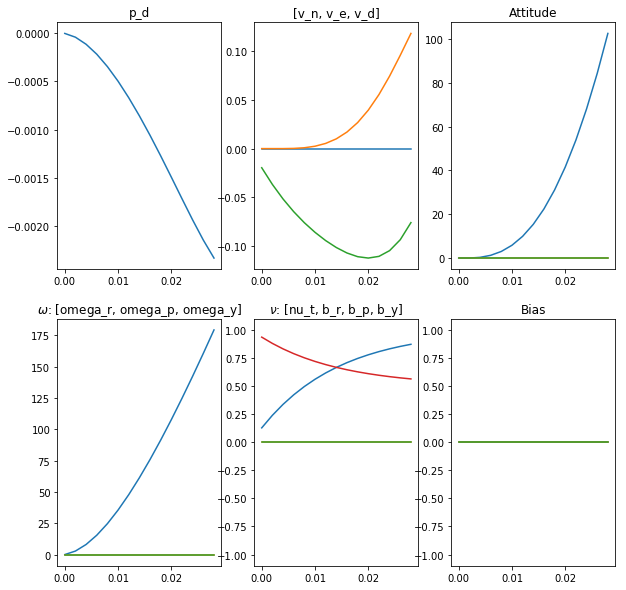

In [24]:
""" Check the torques spool up at about the correct rate """
x0 = np.zeros((N,1))
x0[4] = 1
x0[5] = 0.0
x0[14] = 1 # start throttle at hover

P0 = np.eye(N)

T = int(0.015 * 2 * 500) # two time constants with tau of 0.015 at 500 Hz
history = np.zeros((N,T))

u0 = np.array([1.0, 0.0, 0.0, 0.5])
for i in range(T):

    xnew, Pnew = prediction(x0, P0, u0)

    xnew = normalize_state(xnew)
    history[:,i] = np.array(xnew)[:,0]
    x0 = xnew
    P0 = Pnew

if history.shape[1] > 0: plot_history(history)

In [29]:
import numpy as np
import sympy as sm

def zero_state():
    x0 = np.zeros((N,1))
    x0[4] = 1
    x0[5] = 0.0
    x0[14] = 0.5
    return x0

def python_steady_state(x0 = zero_state(),
                 u0 = np.array([[0.0],[0],[0],[0.5]]),
                 P0 = np.eye(N),
                 a = np.array([[0.0], [0.0], [-9.81]]),
                 g = np.array([[0.0], [0.0], [0.0]]),
                 m = np.array([[1.0], [0.0]]),
                 b = 0, 
                 T=1000, Ts=1./500):

    history = np.zeros((N,T))
    for i in range(T):

        xnew, Pnew = prediction(x0, P0, u0)

        #_, _, K = correction_accel_gyro(xnew, Pnew, a, g)
        xnew, Pnew, K = correction_gyro(xnew, Pnew, g)
        xnew, Pnew, _ = correction_accel(xnew, Pnew, a)
        #xnew, Pnew, _ = correction_mag(xnew, Pnew, m)

        xnew, Pnew, _ = correction_baro(xnew, Pnew, 0)
        xnew = normalize_state(xnew)
        history[:,i] = np.array(xnew)[:,0]
        x0 = xnew
        P0 = Pnew
    
    return history

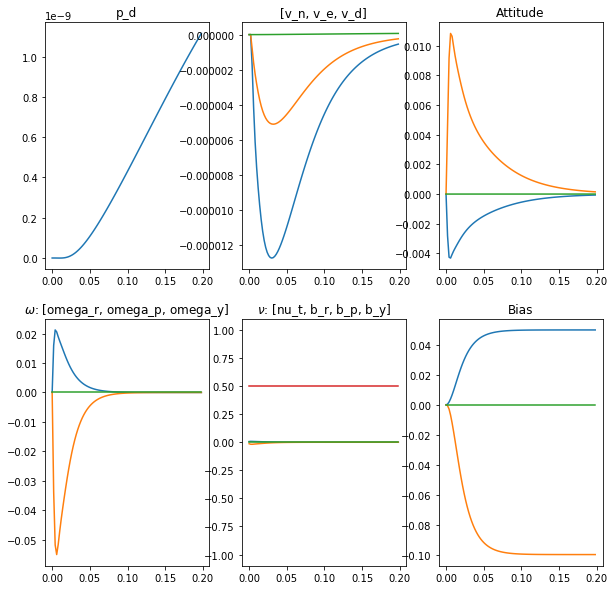

In [33]:
""" Check bias converges """
u0 = np.array([0.05, -0.1, 0.0, 0.5])
history = python_steady_state(u0=u0,T=100)
if history.shape[1] > 0: plot_history(history)

In [ ]:
              
x0 = np.zeros((N,1))
x0[4] = 1
x0[5] = 0.0
x0[14] = 1 # start throttle at hovver

# TO DEBUG!
# There is enough "error" in teh gyro update here that it drives the
# attitude backward from the direction it should be going. Even with both
# gyro and input point the opposite direction. The rate predicts rolling
# right and the attitude is integrating to the left. Even without accel
# corrections.
u0 = np.array([0.5, 0.0, 0.0, 0.5])
g = np.array([[0.01], [0.0], [0.0]])
history = python_steady_state(x0=x0,u0=u0,g=g,T=10)

if history.shape[1] > 0: plot_history(history)

In [34]:
x0 = np.zeros((N,1))
x0[4] = 0.5
x0[5] = 0.5
x0[14] = 1 # start throttle at hovver

# TO DEBUG!
# There is a degenerate solution where initialized on the
# side and give inputs I would hope correspond to vertical
# it continues to think it is on the side

u0 = np.array([0.0, 0.0, 0.0, 0.5])
g = np.array([[0.00], [0.0], [0.0]])
history = python_steady_state(x0=x0,u0=u0,g=g,T=500)

if history.shape[1] > 0: plot_history(history)
(get_rpy(history[:,0]), get_rpy(history[:,-1]))

KeyboardInterrupt: 

In [ ]:
x0 = np.zeros((N,1))
x0[4] = 1
x0[5] = 0.1
x0[14] = 1 # start throttle at hovver

history = python_steady_state(x0=x0,T=100)

if history.shape[1] > 0: plot_history(history)

# Now to manipulate this and generate some efficient C code
## Helper functions

In [47]:
# Some helper functions to optimize the variable/matrix handling

def sparse_and_symbolize_matrix(m, name, N=N):
    """ create a version of this matrix where there is a symbol
        for each non-zero element and the rest of the elements are
        zero, so that it can be used for multiplications to create
        appropriately sparse algebra and use pre-cached values
    """

    import numpy as np
    m_sp = np.array(m)
    m_sp[np.nonzero(m)] = tuple(s for s in sm.MatrixSymbol(name, np.count_nonzero(m), 1))
    return sm.ImmutableMatrix(m_sp)

def vectorize_nonzero(m, template=None):
    """ returns the nonzero components of matrix as a vector. used for storing
        the "sparsified" matrix like as above
    """
    import numpy as np
    # convert to a numpy column array
    m = np.matrix(m).ravel().transpose()
    # and return the nonzero elements
    return sm.ImmutableMatrix(m[np.nonzero(m)[0]])

def symmetric_sparse_covariance(name, template):
    """ create a sparse covariance matrix
    
        The covariance matrix will use a template for the non-zero
        terms and will have a symbol with linear indices filling it.
        They will be used to make it symmetric so it can be used in
        place of a full covariance matrix to calculate correct math.
    """
    
    import numpy as np
    
    template = np.matrix(template)
    idx = [z for z in zip(*np.nonzero(np.triu(template)))]
    
    N = template.shape[0]
    Nl = len(idx)
    
    m_den = sm.MatrixSymbol(name, Nl, 1)
    m_sym = sm.zeros(N,N)
    
    for i, c in enumerate(idx):
        m_sym[c[0],c[1]] = m_den[i,0]
        m_sym[c[1],c[0]] = m_den[i,0]        
    
    def vectorize_covariance(mat):
        return sm.ImmutableMatrix([mat[c[0],c[1]] for c in idx])
        
    return m_sym, Nl, vectorize_covariance

def inv2x2(m):
    # from https://www.dr-lex.be/random/matrix-inv.html
    assert m.shape == (2,2)
    det = m.det()
    inv = sm.Matrix([[m[1,1], -m[0,1]],
                     [-m[1,0], m[0,0]]])
    return inv / det

def inv3x3(m):
    # from https://www.dr-lex.be/random/matrix-inv.html
    assert m.shape == (3,3)
    det = m.det()
    inv = sm.Matrix([[m[1,1]*m[2,2]-m[1,2]*m[2,1], m[0,2]*m[2,1]-m[0,1]*m[2,2], m[0,1]*m[1,2]-m[0,2]*m[1,1]],
                     [m[1,2]*m[2,0]-m[1,0]*m[2,2], m[0,0]*m[2,2]-m[0,2]*m[2,0], m[0,2]*m[1,0]-m[0,0]*m[1,2]],
                     [m[1,0]*m[2,1]-m[1,1]*m[2,0], m[0,1]*m[2,0]-m[0,0]*m[2,1], m[0,0]*m[1,1]-m[0,1]*m[1,0]]])
    return inv / det

def decorrelate(P, uncorrelated):
    """ take a list of tuples of variables and make them uncorrelated """
    
    def _state_idx(sym):
        return [i for i,v in enumerate(state) if v == sym][0]

    for u in uncorrelated:
        for u0 in u:
            i = _state_idx(u0)
            for u1 in u:
                j = _state_idx(u1)
                if i == j:
                    continue
                P[i,j] = 0
    return P

def decorrelate_pairwise_list(v1, vlist):
    return [(v1, v) for v in vlist]

## Set up main math expressions

Covariance has 87 terms


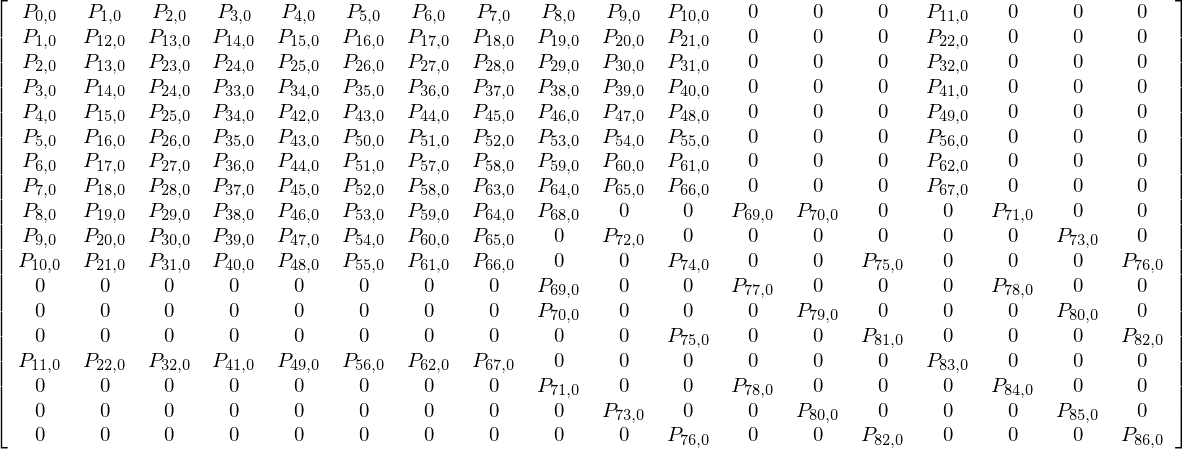

In [61]:
N = state.shape[0]

# State prediction step
xnew = state + f * Ts

# Covariance prediction step

# Note we have a noise term for every state variable, so G (df/dw) is not used
Q = sm.diag(*sm.MatrixSymbol('Q', N, 1))

# declare certain state variables uncorrelated to massively
# reduce the computation
uncorrelated = [   
    # keep the bias terms only covarying with their roll, torque and the attitude
    *decorrelate_pairwise_list(b_r, [b_p, b_y, nu_p, nu_y, nu_t, omega_p, omega_y, v_n, v_e, v_d, p_d]),
    *decorrelate_pairwise_list(b_p, [b_r, b_y, nu_r, nu_y, nu_t, omega_r, omega_y, v_n, v_e, v_d, p_d]),
    *decorrelate_pairwise_list(b_y, [b_r, b_p, nu_r, nu_p, nu_t, omega_r, omega_p, v_n, v_e, v_d, p_d]),

    # do not cross couple torques and throttle
    (nu_t, nu_r, nu_p, nu_y),
    *decorrelate_pairwise_list(nu_r, [omega_p, omega_y, v_n, v_e, v_d, p_d]),
    *decorrelate_pairwise_list(nu_p, [omega_p, omega_y, v_n, v_e, v_d, p_d]),
    *decorrelate_pairwise_list(nu_y, [omega_r, omega_p, v_n, v_e, v_d, p_d]),

    # TODO: confirm how important keeping the bias and torque correlated with attitude is
    *decorrelate_pairwise_list(q0, [nu_r, nu_p, nu_y, b_r, b_p, b_y]),
    *decorrelate_pairwise_list(q1, [nu_r, nu_p, nu_y, b_r, b_p, b_y]),
    *decorrelate_pairwise_list(q2, [nu_r, nu_p, nu_y, b_r, b_p, b_y]),
    *decorrelate_pairwise_list(q3, [nu_r, nu_p, nu_y, b_r, b_p, b_y]),
    
    # do not correlate throttle with rotation rates or the rotation rates with each other
    (nu_t, omega_r, omega_p, omega_y),
    
    # TODO: determine if we can decorrelate altitude from attitude. likely not since the
    # baro update provides information which way is up.
    #*decorrelate_pairwise_list(p_d, [q0, q1, q2, q3]),
]

# Create a symmetrical covariance matrix.
cov_template = decorrelate(sm.ones(N,N), uncorrelated)
P, num_cov_terms, vectorize_covariance = symmetric_sparse_covariance('P', cov_template)
print("Covariance has {} terms".format(num_cov_terms))

# Create helper variable that is the values in the F matrix that are non-zero
# which simplifies the algebra. Note that this is a dense representation right
# now requires memory for all elements in F to be be allocated
# TODO: represent F as vector indexing directly to non-zero elements
Fsp = sparse_and_symbolize_matrix(F, 'F')
Hsp = sparse_and_symbolize_matrix(H, 'H')

# Calculate the prediction of the covariance. This represents P as a linear
# set of indices into the upper triangular component of the covariance matrix
# so halves the memory requirements and does not duplicate the calculation of
# the bottom triangular half.
# Note that Fsp is very intentionally _NOT_ multipled by Ts here as this is
# already factored into Fsp
Pnew = (sm.eye(N) + Fsp) * P * (sm.eye(N) + Fsp).transpose() + Q  # G * Q * G.transpose()

#assert Pnew.is_symmetric()

# variables that will be used below
M = H.shape[0]
K_out = sm.MatrixSymbol('K', N, M)
Pnew_out = sm.MatrixSymbol('Pnew', num_cov_terms, 1)
s_P = sm.MatrixSymbol('P', num_cov_terms, 1)
s_Q = sm.MatrixSymbol('Q', N, 1)
s_R = sm.MatrixSymbol('R', H.shape[0], 1)
xnew_out = sm.MatrixSymbol('xnew', N, 1)

# Create cython functions for prediction and measurement steps

In [62]:
# NOTE: To make this work cleanly I made the functions above using MatrixSymbols
# instead of symbols(blah_:N). That is important for the input and output argument
# formatting for codegen. However, MatrixSymbols break cse. When switching back to
# this I will need to do some workarounds to do the cse with the original format and
# then right before generating the code actually convert back to MatrixSymbol format.
from sympy.utilities.codegen import codegen
from sympy.utilities.codegen import CCodeGen
from sympy.utilities.autowrap import autowrap

from sympy.printing.ccode import C99CodePrinter
class FloatPrinter(C99CodePrinter):
    """ Printer"""
    
    from sympy.codegen.ast import real, float32
    type_aliases = {
        real: float32,
    }
        
    def _print_Pow(self, expr):
        if expr.exp.is_integer and expr.exp.is_number and expr.exp == 2:
            return '(' + '*'.join([self._print(expr.base)]*expr.exp) + ')'
        else:
            return super(FloatPrinter, self)._print_Pow(expr)

generator = CCodeGen(cse=True, printer=FloatPrinter())
codegen_args = {'header': False, 'empty': False, 'code_gen': generator}
autowrap_args = {'backend': 'cython', 'tempdir': 'autowraptmp_custom', 'code_gen': generator}

# replace some variables with vector versions for parameter handling in C
m = dict()
s_x = sm.MatrixSymbol('x', N, 1)
m.update(dict(zip(state, s_x)))
s_u = sm.MatrixSymbol('u', u.shape[0], 1)
m.update(dict(zip(u, s_u)))
s_params = sm.MatrixSymbol('param', 11, 1)
m.update(dict(zip([*symbols('g beta_r beta_p beta_y1 beta_y2 beta_t tau mu'), *Matrix(MatrixSymbol('Be',3,1))], 
                  s_params)))

F_out = sm.MatrixSymbol('F', vectorize_nonzero(Fsp).shape[0], 1)
H_out = sm.MatrixSymbol('H', vectorize_nonzero(Hsp).shape[0], 1)

Ts = symbols('Ts')

In [65]:
# compute a time step prediction of the state
xnew_out = sm.MatrixSymbol('xnew', N, 1)
[(c_name, c_code), (h_name, h_header)] = codegen(('state_prediction', sm.Eq(xnew_out, xnew.xreplace(m))),
                                                 argument_sequence=(s_x, s_u, Ts, s_params, xnew_out),
                                                 **codegen_args)

print(c_code)
# make it a local function to use
xnew_func = autowrap(sm.Eq(xnew_out, xnew.xreplace(m)), args=(s_x, s_u, Ts, s_params, xnew_out),
                     **autowrap_args)

#include "state_prediction.h"
#include <math.h>
void state_prediction(double *x, double *u, double Ts, double *param, double *xnew) {
   const double x0 = 2*param[0]*param[5]*x[14];
   const double x1 = x[4]*x[6];
   const double x2 = x[5]*x[7];
   const double x3 = 2*x[4]*x[7];
   const double x4 = x3 - 2*x[5]*x[6];
   const double x5 = 2*x[3];
   const double x6 = x[4]*x[5];
   const double x7 = x[6]*x[7];
   const double x8 = x6 + x7;
   const double x9 = (x[4]*x[4]);
   const double x10 = (x[5]*x[5]);
   const double x11 = -x10 + x9;
   const double x12 = (x[6]*x[6]);
   const double x13 = (x[7]*x[7]);
   const double x14 = -x13;
   const double x15 = x11 + x12 + x14;
   const double x16 = x15*x[2] - x4*x[1] + x5*x8;
   const double x17 = x16*param[7];
   const double x18 = -x12;
   const double x19 = x10 + x14 + x18 + x9;
   const double x20 = x3 + 2*x[5]*x[6];
   const double x21 = x1 - x2;
   const double x22 = x19*x[1] + x20*x[2] - x21*x5;
   const double x23 = x22*param[7];
  

In [67]:
# linearize the system dynamics at the current state variable
eq = [sm.Eq(F_out, vectorize_nonzero(F).xreplace(m)),sm.Eq(H_out, vectorize_nonzero(H).xreplace(m))]
args = (s_x, Ts, s_params, F_out, H_out)
[(c_name, c_code), (h_name, h_header)] = codegen(('linearize_FH', eq),
                                                 argument_sequence=args,
                                                 **codegen_args)
print(c_code)
linearize_FH_func = autowrap( eq, args=args,
                             **autowrap_args)

#include "linearize_FH.h"
#include <math.h>
void linearize_FH(double *x, double Ts, double *param, double *F, double *H) {
   const double x0 = 2*x[4];
   const double x1 = x0*x[7];
   const double x2 = 2*x[5];
   const double x3 = x2*x[6];
   const double x4 = -x1 + x3;
   const double x5 = (x[4]*x[4]);
   const double x6 = (x[5]*x[5]);
   const double x7 = (x[6]*x[6]);
   const double x8 = -x7;
   const double x9 = (x[7]*x[7]);
   const double x10 = -x9;
   const double x11 = x10 + x5 + x6 + x8;
   const double x12 = x4*param[7];
   const double x13 = x5 - x6;
   const double x14 = x10 + x13 + x7;
   const double x15 = x1 + x3;
   const double x16 = x15*param[7];
   const double x17 = Ts*(-x11*x16 - x12*x14);
   const double x18 = x0*x[5];
   const double x19 = 2*x[6];
   const double x20 = x19*x[7];
   const double x21 = x18 + x20;
   const double x22 = x21*param[7];
   const double x23 = x0*x[6];
   const double x24 = x2*x[7];
   const double x25 = -x23 + x24;
   const double x26 =

In [68]:
# compute the covariance prediction forward a time step
eq = sm.Eq(Pnew_out, vectorize_covariance(Pnew).xreplace(m))
args = (s_P, F_out, s_Q, Pnew_out)
[(c_name, c_code), (h_name, h_header)] = codegen(('covariance_prediction', eq), argument_sequence=args,
                                                 **codegen_args)
print(c_code)
# make it a local function to use
Pnew_func = autowrap(eq, args=args, **autowrap_args)

#include "covariance_prediction.h"
#include <math.h>
void covariance_prediction(double *P, double *F, double *Q, double *Pnew) {
   const double x0 = F[0]*P[33] + P[3];
   const double x1 = F[0]*P[24] + P[2];
   const double x2 = F[0]*P[34] + P[4];
   const double x3 = F[0]*P[35] + P[5];
   const double x4 = F[0]*P[36] + P[6];
   const double x5 = F[0]*P[37] + P[7];
   const double x6 = F[0]*P[41] + P[11];
   const double x7 = F[1] + 1;
   const double x8 = F[0]*P[14] + P[1];
   const double x9 = F[10] + 1;
   const double x10 = F[19] + 1;
   const double x11 = F[0]*P[38] + P[8];
   const double x12 = F[0]*P[39] + P[9];
   const double x13 = F[0]*P[40] + P[10];
   const double x14 = F[59] + 1;
   const double x15 = x7*P[13] + F[2]*P[23] + F[3]*P[24] + F[4]*P[25] + F[5]*P[26] + F[6]*P[27] + F[7]*P[28] + F[8]*P[32];
   const double x16 = x7*P[14] + F[2]*P[24] + F[3]*P[33] + F[4]*P[34] + F[5]*P[35] + F[6]*P[36] + F[7]*P[37] + F[8]*P[41];
   const double x17 = x7*P[15] + F[2]*P[25] + F[3]*

In [69]:
# calculate the Kalman gain. This uses a sequential update formula
# to calculate K = (P * H.transpose()) / (H*P*H.transpose() + R)
# assuming the R are independent

sequential = False

if sequential:
    M = H.shape[0]
    K = sm.zeros(N,M)
    s_R = sm.MatrixSymbol('R', H.shape[0], 1)
    for i in range(M):
        HP = Hsp[i,:] * P
        HPHR = s_R[i] + (HP * Hsp[i,:].transpose())[0]
        K[:,i] =(HP / HPHR).transpose()

In [70]:
# compute the baro measurement correction
baro = sm.Symbol('baro')
err = h[0,0] - baro

if sequential:
    xcor_b = sm.ImmutableMatrix(state - K[:,0]*err)
    Pcor_b = sm.Matrix(sm.eye(N) - K[:,0]*Hsp[0,:]) * P
else:
    Hb = Hsp[0,:]
    Hinv = (Hb*P*Hb.transpose() + sm.Matrix([s_R[0,0]]))**-1
    K = (P * Hb.transpose()) * Hinv

    xcor_b = sm.Matrix(state - K*err)
    Pcor_b = sm.Matrix((sm.eye(N) - K*Hb) * P)

    
baro_eqs = [sm.Eq(xnew_out, xcor_b.xreplace(m)), sm.Eq(Pnew_out, vectorize_covariance(Pcor_b).xreplace(m))]
args = (s_x, s_P, baro, H_out, s_R, xnew_out, Pnew_out)

[(c_name, c_code), (h_name, h_header)] = codegen(('baro_correction',baro_eqs), argument_sequence=args,
                                                  **codegen_args)
print(c_code)
baro_correction = autowrap(baro_eqs, args=args, **autowrap_args)

#include "baro_correction.h"
#include <math.h>
void baro_correction(double *x, double *P, double baro, double *H, double *R, double *xnew, double *Pnew) {
   const double x0 = (H[0]*H[0]);
   const double x1 = x0*P[0];
   const double x2 = 1.0F/(x1 + R[0]);
   const double x3 = x2*(-baro + x[0])*H[0];
   const double x4 = -x1*x2 + 1;
   const double x5 = x0*x2;
   const double x6 = x0*x2*P[1];
   const double x7 = x0*x2*P[2];
   const double x8 = x0*x2*P[3];
   const double x9 = x0*x2*P[4];
   const double x10 = x0*x2*P[5];
   const double x11 = x0*x2*P[6];
   const double x12 = x0*x2*P[7];
   xnew[0] = -x3*P[0] + x[0];
   xnew[1] = -x3*P[1] + x[1];
   xnew[2] = -x3*P[2] + x[2];
   xnew[3] = -x3*P[3] + x[3];
   xnew[4] = -x3*P[4] + x[4];
   xnew[5] = -x3*P[5] + x[5];
   xnew[6] = -x3*P[6] + x[6];
   xnew[7] = -x3*P[7] + x[7];
   xnew[8] = -x3*P[8] + x[8];
   xnew[9] = -x3*P[9] + x[9];
   xnew[10] = -x3*P[10] + x[10];
   xnew[11] = x[11];
   xnew[12] = x[12];
   xnew[13] = x[13];
   xne

In [71]:
# compute the gyro measurement correction
gyro = sm.MatrixSymbol('gyro', 3, 1)
err = h[4:7,0] - gyro

if sequential:
    xcor_g = sm.Matrix(state - K[:,4:7]*err)
    # when using the iterative updates based on the Kalman updates calculated
    # above these should be applied serially to update the covariance
    Pcor_g = sm.Matrix(  sm.Matrix(sm.eye(N) - K[:,4]*Hsp[4,:]) * 
                         sm.Matrix(sm.eye(N) - K[:,5]*Hsp[5,:]) * 
                         sm.Matrix(sm.eye(N) - K[:,6]*Hsp[6,:]) * P )
else:
    # calculate the gain using analytic inverse of 3x3 matrix
    Hg = Hsp[4:7,:]
    R = sm.diag(*s_R[4:7])
    Hinv = inv3x3(Hg*P*Hg.transpose() + R)
    K = (P * Hg.transpose()) * Hinv

    xcor_g = sm.Matrix(state - K*err)
    Pcor_g = sm.Matrix((sm.eye(N) - K*Hg) * P)

gyro_eqs = [sm.Eq(xnew_out, xcor_g.xreplace(m)), sm.Eq(Pnew_out, vectorize_covariance(Pcor_g).xreplace(m))]
args = (s_x, s_P, gyro, H_out, s_R, xnew_out, Pnew_out)

[(c_name, c_code), (h_name, h_header)] = codegen(('gyro_correction', gyro_eqs), argument_sequence=args,
                                                 **codegen_args)
print(c_code)
gyro_correction = autowrap(gyro_eqs, args=args, **autowrap_args)

#include "gyro_correction.h"
#include <math.h>
void gyro_correction(double *x, double *P, double *gyro, double *H, double *R, double *xnew, double *Pnew) {
   const double x0 = (H[16]*H[16]);
   const double x1 = x0*P[68];
   const double x2 = 1.0F/(x1 + R[4]);
   const double x3 = x2*(-gyro[0] + x[8])*H[16];
   const double x4 = (H[17]*H[17]);
   const double x5 = x4*P[72];
   const double x6 = 1.0F/(x5 + R[5]);
   const double x7 = x6*(-gyro[1] + x[9])*H[17];
   const double x8 = (H[18]*H[18]);
   const double x9 = x8*P[74];
   const double x10 = 1.0F/(x9 + R[6]);
   const double x11 = x10*(-gyro[2] + x[10])*H[18];
   const double x12 = x0*x2;
   const double x13 = x4*x6;
   const double x14 = x10*x8;
   const double x15 = x0*x2*P[8];
   const double x16 = x4*x6*P[9];
   const double x17 = x10*x8*P[10];
   const double x18 = x1*x2;
   const double x19 = x5*x6;
   const double x20 = x10*x9;
   const double x21 = x0*x2*P[19];
   const double x22 = x4*x6*P[20];
   const double x23 = x10

In [72]:
# compute the mag measurement correction
mag = sm.MatrixSymbol('mag', 2, 1)
err = sm.simplify(h[7:9,0] - mag)

if sequential:
    xcor_m = sm.Matrix(state - K[:,7:9]*err)
    # when using the iterative updates based on the Kalman updates calculated
    # above these should be applied serially to update the covariance
    Pcor_m = sm.Matrix(  sm.Matrix(sm.eye(N) - K[:,7]*Hsp[7,:]) * 
                         sm.Matrix(sm.eye(N) - K[:,8]*Hsp[8,:]) * P )
else:
    # calculate the gain using analytic inverse of 3x3 matrix
    Hm = Hsp[7:9,:]
    R = sm.diag(*s_R[7:9])
    Hinv = inv2x2(Hm*P*Hm.transpose() + R)
    K = (P * Hm.transpose()) * Hinv

    xcor_m = sm.Matrix(state - K*err)
    Pcor_m = sm.Matrix((sm.eye(N) - K*Hm) * P)

mag_eqs = [sm.Eq(xnew_out, xcor_m.xreplace(m)), sm.Eq(Pnew_out, vectorize_covariance(Pcor_m).xreplace(m))]
args = (s_x, s_P, mag, H_out, s_R, s_params, xnew_out, Pnew_out)

[(c_name, c_code), (h_name, h_header)] = codegen(('mag_correction', mag_eqs), argument_sequence=args,
                                                 **codegen_args)
print(c_code)
mag_correction = autowrap(mag_eqs, args=args, **autowrap_args)

#include "mag_correction.h"
#include <math.h>
void mag_correction(double *x, double *P, double *mag, double *H, double *R, double *param, double *xnew, double *Pnew) {
   const double x0 = 2*param[10];
   const double x1 = x[4]*x[7];
   const double x2 = x[5]*x[6];
   const double x3 = (x[4]*x[4]) - (x[7]*x[7]);
   const double x4 = (x[6]*x[6]);
   const double x5 = (x[5]*x[5]);
   const double x6 = x0*(x[4]*x[5] + x[6]*x[7]) - 2*(x1 - x2)*param[8] + (x3 + x4 - x5)*param[9] - mag[1];
   const double x7 = H[19]*P[4] + H[20]*P[5] + H[21]*P[6] + H[22]*P[7];
   const double x8 = H[19]*P[42] + H[20]*P[43] + H[21]*P[44] + H[22]*P[45];
   const double x9 = x8*H[23];
   const double x10 = H[19]*P[43] + H[20]*P[50] + H[21]*P[51] + H[22]*P[52];
   const double x11 = x10*H[24];
   const double x12 = H[19]*P[44] + H[20]*P[51] + H[21]*P[57] + H[22]*P[58];
   const double x13 = x12*H[25];
   const double x14 = H[19]*P[45] + H[20]*P[52] + H[21]*P[58] + H[22]*P[63];
   const double x15 = x14*H[26];
  

In [73]:
# compute the accel measurement correction
accel = sm.MatrixSymbol('accel', 3, 1)
err = sm.simplify(h[1:4,0] - accel)

if sequential:
    xcor_a = sm.Matrix(state - K[:,1:4]*err)
    # when using the iterative updates based on the Kalman updates calculated
    # above these should be applied serially to update the covariance
    Pcor_a = sm.Matrix(  sm.Matrix(sm.eye(N) - K[:,1]*Hsp[1,:]) * 
                         sm.Matrix(sm.eye(N) - K[:,2]*Hsp[2,:]) * 
                         sm.Matrix(sm.eye(N) - K[:,3]*Hsp[3,:]) * P )
else:
    # calculate the gain using analytic inverse of 3x3 matrix
    Ha = Hsp[1:4,:]
    R = sm.diag(*s_R[1:4])
    Hinv = inv3x3(Ha*P*Ha.transpose() + R)
    K = (P * Ha.transpose()) * Hinv

    xcor_a = sm.Matrix(state - K*err)
    Pcor_a = sm.Matrix((sm.eye(N) - K*Ha) * P)

accel_eqs = [sm.Eq(xnew_out, xcor_a.xreplace(m)), sm.Eq(Pnew_out, vectorize_covariance(Pcor_a).xreplace(m))]
args = (s_x, s_P, accel, H_out, s_R, s_params, xnew_out, Pnew_out)

[(c_name, c_code), (h_name, h_header)] = codegen(('accel_correction', accel_eqs), argument_sequence=args,
                                                 **codegen_args)
print(c_code)
accel_correction = autowrap(accel_eqs, args=args, **autowrap_args)

#include "accel_correction.h"
#include <math.h>
void accel_correction(double *x, double *P, double *accel, double *H, double *R, double *param, double *xnew, double *Pnew) {
   const double x0 = 2*x[3];
   const double x1 = x[4]*x[7];
   const double x2 = x[5]*x[6];
   const double x3 = (x[4]*x[4]) - (x[7]*x[7]);
   const double x4 = (x[6]*x[6]);
   const double x5 = (x[5]*x[5]);
   const double x6 = -(x0*(x[4]*x[5] + x[6]*x[7]) - 2*(x1 - x2)*x[1] + (x3 + x4 - x5)*x[2])*param[7] - accel[1];
   const double x7 = H[1]*P[1] + H[2]*P[2] + H[3]*P[3] + H[4]*P[4] + H[5]*P[5] + H[6]*P[6] + H[7]*P[7];
   const double x8 = H[1]*P[22];
   const double x9 = H[2]*P[32];
   const double x10 = H[3]*P[41];
   const double x11 = H[4]*P[49];
   const double x12 = H[5]*P[56];
   const double x13 = H[6]*P[62];
   const double x14 = H[7]*P[67];
   const double x15 = x10 + x11 + x12 + x13 + x14 + x8 + x9;
   const double x16 = x15*H[15];
   const double x17 = H[8]*P[22];
   const double x18 = H[9]*P[32];
  

KeyboardInterrupt: 

In [74]:
P0 = sm.MatrixSymbol('P0',N,1)
eq = sm.Eq(Pnew_out, vectorize_covariance(sm.diag(*P0)))
args = (Pnew_out, P0)
[(c_name, c_code), (h_name, h_header)] = codegen(('covariance_init', eq), argument_sequence=args,
                                                 **codegen_args)
print(c_code)
# make it a local function to use
Pinit_func = autowrap(eq, args=args, **autowrap_args)

#include "covariance_init.h"
#include <math.h>
void covariance_init(double *Pnew, double *P0) {
   Pnew[0] = P0[0];
   Pnew[1] = 0;
   Pnew[2] = 0;
   Pnew[3] = 0;
   Pnew[4] = 0;
   Pnew[5] = 0;
   Pnew[6] = 0;
   Pnew[7] = 0;
   Pnew[8] = 0;
   Pnew[9] = 0;
   Pnew[10] = 0;
   Pnew[11] = 0;
   Pnew[12] = P0[1];
   Pnew[13] = 0;
   Pnew[14] = 0;
   Pnew[15] = 0;
   Pnew[16] = 0;
   Pnew[17] = 0;
   Pnew[18] = 0;
   Pnew[19] = 0;
   Pnew[20] = 0;
   Pnew[21] = 0;
   Pnew[22] = 0;
   Pnew[23] = P0[2];
   Pnew[24] = 0;
   Pnew[25] = 0;
   Pnew[26] = 0;
   Pnew[27] = 0;
   Pnew[28] = 0;
   Pnew[29] = 0;
   Pnew[30] = 0;
   Pnew[31] = 0;
   Pnew[32] = 0;
   Pnew[33] = P0[3];
   Pnew[34] = 0;
   Pnew[35] = 0;
   Pnew[36] = 0;
   Pnew[37] = 0;
   Pnew[38] = 0;
   Pnew[39] = 0;
   Pnew[40] = 0;
   Pnew[41] = 0;
   Pnew[42] = P0[4];
   Pnew[43] = 0;
   Pnew[44] = 0;
   Pnew[45] = 0;
   Pnew[46] = 0;
   Pnew[47] = 0;
   Pnew[48] = 0;
   Pnew[49] = 0;
   Pnew[50] = P0[5];
   Pnew[51] = 0;
   Pne

# Test autowrap implementation

In [ ]:
# Test the steady state values for various constant inputs

def normalize_state(x):
    q_idx = 4
    q = x[q_idx:q_idx+4]
    norm = np.sqrt(np.matmul(q.transpose(), q))    
    for i in np.arange(q_idx, q_idx+4):
        x[i] = x[i] / norm
    return x

def steady_state(x0 = np.zeros((N,1)),
                 u0 = np.array([[0.0],[0],[0],[1]]),
                 P0 = np.array(vectorize_covariance(np.eye(N))).astype(np.float64),
                 a = np.array([[0.0, 0.0, 9.81]]), g = np.zeros((3,1)), b = 0, 
                 R0 = np.ones((M,1)),
                 Q0 = np.matrix([1e-5, 1e-5, 1e-5, 1e-5,
                                1e-5, 1e-5, 1e-5, 1e-5,
                                1e-3, 1e-3, 1e-3,
                                1e-1, 1e-1, 1e-1, 1e-1]),

                 # params: g beta1 tau mu
                 params = np.array([[9.81, 1000., 0.015, 1]]),
                 T=1000, Ts=1./500.):
    
    history = np.zeros((N,T))

    for i in range(T):
        x1 = xnew_func(x0, u0, Ts, params)

        Flin, Hlin = linearize_FH_func(x0, params)
        P1 = Pnew_func(P0, Ts, Flin, Q0)

        x1, P1 = gyro_correction(x1, P1, g, Hlin, R0)
        x1, P1 = accel_correction(x1, P1, a, Hlin, R0, params)

        if i % 20 == 19:
            x1, P1 = baro_correction(x1, P1, b, Hlin, R0)

        x1 = normalize_state(x1)

        history[:,i] = x1[:,0]
        x0 = x1
        P0 = P1
    
    return history, P1

import numpy as np
import sympy as sm

x0 = np.zeros((N,1))
# start at slightly rotated angle
x0[4] = 1
x0[5] = 0.1
# start with no throttle
x0[14] = 0.0

u0 = np.array([[0.0, 0.0, 0.0, 0.9]])

# set up a steady state "angle"
a = np.array([[0.0, 1.0, -6.81]])
g = np.array([[0.0, 0.0, 1.0]])

# create initial covariance and pack it up
P0 = np.array(vectorize_covariance(np.eye(N))).astype(np.float64)

R0 = np.array([[100.0, 1e-1, 1e-1, 1e-1, 1e-3, 1e-3, 1e-3]])
R0 = np.ones((7,1))
R0[0] = 100

history, Pout = steady_state(x0, u0, a=a, g=g, b=1, T=1500, R0=R0)
plot_history(history)

# Sanity checks to compare python and cython implementations

In [ ]:
""" Some Unit tests to compare the python and cython implementations """

np.random.seed(seed=0)

R0 = np.ones((M,1))
Q0 = np.ones((N,1))
u0 = np.zeros((4,1))
params = np.array([[9.81, 1000., 0.015, 1]])
Ts = 1./500.

T = 4

def cov_error(cov_py, cov_c):
    return np.abs(np.array(vectorize_covariance(cov_py)-P1_c))

def normalize_state(x):
    q_idx = 4
    q = x[q_idx:q_idx+4]
    norm = np.sqrt(np.matmul(q.transpose(), q))    
    for i in np.arange(q_idx, q_idx+4):
        x[i] = x[i] / norm
    return x

# check prediction step produces similar results
err = 0
x_err = 0
for i in range(T):
    x0 = np.random.randn(N,1)
    x0 = normalize_state(x0)
    P0 = np.diag(np.abs(np.random.randn(N)))

    # perform prediction with python implementation
    x1_py, P1_py = prediction(x0, P0, u0, dt=Ts)
    
    # perform prediction with cython code
    P0_c = np.array(vectorize_covariance(P0)).astype(np.float64)
    Flin, Hlin = linearize_FH_func(x0, params)
    x1_c = xnew_func(x0, u0, Ts, params)
    P1_c = Pnew_func(P0_c, Ts, Flin, Q0)

    # check state prediction is similar
    #assert np.all(np.abs(np.array(x1_py-x1_c))< 1e-15), "Prediction state error {}".format(i)
    
    # check covariance prediction is similar
    p_err = cov_error(P1_py, P1_c)
    #assert np.all(p_err < 1e-1), "Prediction covariance error iter {} with max {}".format(i, np.max(p_err))

    err = np.max([err, np.max(p_err)])
    x_err = np.max([x_err, np.max(np.abs(np.array(x1_py-x1_c)))])    

print("Prediction. Max cov diff: {}. Max state diff: {}".format(err, x_err))

# check baro measurement
err = 0
x_err = 0
for i in range(T):
    x0 = np.random.randn(N,1)
    x0 = normalize_state(x0)
    P0 = np.diag(np.abs(np.random.randn(N)))
    b = np.random.randn(1,1)[0,0]
    
    x1_py, P1_py, _ = correction_baro(x0, P0, b)
    
    Flin, Hlin = linearize_FH_func(x0, params)
    P0_c = np.array(vectorize_covariance(P0)).astype(np.float64)
    x1_c, P1_c = baro_correction(x0, P0_c, b, Hlin, R0)

    # check state prediction is similar
    #assert np.all(np.abs(np.array(x1_py-x1_c))< 1e-5), "Prediction state error {}".format(i)
    p_err = cov_error(P1_py, P1_c)
    #assert np.all(p_err < 1e-10), "Prediction covariance error iter {} with max {}".format(i, np.max(p_err))
    
    err = np.max([err, np.max(p_err)])
    x_err = np.max([x_err, np.max(np.abs(np.array(x1_py-x1_c)))])

print("Baro. Max cov diff: {}. Max state diff: {}".format(err, x_err))

# check gyro measurement
err = 0
x_err = 0
for i in range(T):
    x0 = np.random.randn(N,1)
    x0 = normalize_state(x0)
    P0 = np.diag(np.abs(np.random.randn(N)))
    gyro = np.random.randn(3,1)
    
    x1_py, P1_py, _ = correction_gyro(x0, P0, gyro)
    
    P0_c = np.array(vectorize_covariance(P0)).astype(np.float64)
    x1_c, P1_c = gyro_correction(x0, P0_c, gyro, Hlin, R0)

    # check state prediction is similar
    #assert np.all(np.abs(np.array(x1_py-x1_c))< 1e-5), "Prediction state error {}".format(i)
    p_err = cov_error(P1_py, P1_c)
    #assert np.all(p_err < 1e-10), "Prediction covariance error iter {} with max {}".format(i, np.max(p_err))

    err = np.max([err, np.max(p_err)])
    x_err = np.max([x_err, np.max(np.abs(np.array(x1_py-x1_c)))])

print("Gyro. Max cov diff: {}. Max state diff: {}".format(err, x_err))

# check gyro measurement
err = 0
x_err = 0
for i in range(T):
    x0 = np.random.randn(N,1)
    x0 = normalize_state(x0)
    P0 = np.diag(np.abs(np.random.randn(N)))
    accel = np.random.randn(3,1)
    
    # note a non-sequential accel update is not identical
    #x1_py, P1_py = correction_accel_sequential(x0, P0, accel)
    x1_py, P1_py, _ = correction_accel(x0, P0, accel)
    
    Flin, Hlin = linearize_FH_func(x0, params)
    P0_c = np.array(vectorize_covariance(P0)).astype(np.float64)
    x1_c, P1_c = accel_correction(x0, P0_c, accel, Hlin, R0, params)

    # check state prediction is similar
    # print(np.concatenate((x1_c, np.array(x1_py).astype(np.float64)),axis=1))
    #print(x1_c-x1_py)
    #print(np.concatenate((x1_c, x1_py),axis=1))

    #assert np.all(np.abs(np.array(x1_py-x1_c))< 1e-0), "Accel state error {} with max {}".format(i, np.max(np.abs(np.array(x1_py-x1_c))))
    p_err = cov_error(P1_py, P1_c)
    #assert np.all(p_err < 1e-1), "Accel covariance error iter {} with max {}".format(i, np.max(p_err))
    
    err = np.max([err, np.max(p_err)])
    x_err = np.max([x_err, np.max(np.abs(np.array(x1_py-x1_c)))])

print("Accel. Max cov diff: {}. Max state diff: {}".format(err, x_err))

# Test Cython implementation on log files

In [ ]:
reload(taulabs)

from __future__ import print_function
from taulabs import telemetry, uavo
from taulabs.telemetry import FileTelemetry

print(dir(telemetry))
file_num = 1
if file_num == 0:
    filename = '/Users/jcotton81/Documents/TauLabs/Logs/kf_torque/log_20140327_184240.dat'
    uavo_list = telemetry.FileTelemetry(file(filename, 'rb'),
                                        gcs_timestamps=False, parse_header=False,
                                        githash='lqg')
elif file_num == 1:
    filename = '/Volumes/8TB/flight_logs/20170115-ins14-quad-beach/log_20170115_201058.dat'
    uavo_list = telemetry.FileTelemetry(file(filename, 'rb'),
                                        gcs_timestamps=False, parse_header=False,
                                        githash='ins14')
elif file_num == 2:
    filename = '/Users/jcotton81/Documents/TauLabs/Logs/kf_torque/log_20140327_184254.dat'
    uavo_list = telemetry.FileTelemetry(file(filename, 'rb'),
                                        gcs_timestamps=False, parse_header=False,
                                        githash='lqg')
else:
    raise Exception("Invalid file num")

print('Parsing UAVOs ... ', end="")

import numpy as np
from matplotlib.mlab import find

accels = uavo_list.as_numpy_array(uavo.UAVO_Accels)
gyros = uavo_list.as_numpy_array(uavo.UAVO_Gyros)
actuator = uavo_list.as_numpy_array(uavo.UAVO_ActuatorDesired)
baros = uavo_list.as_numpy_array(uavo.UAVO_BaroAltitude)